In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install pydicom

     |████████████████████████████████| 1.9MB 6.9MB/s 


In [3]:
pip install chart_studio

     |████████████████████████████████| 71kB 4.0MB/s 


In [4]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import cv2
import imutils
import matplotlib.pyplot as plt
from os import listdir
import time    

%matplotlib inline

In [5]:
import pandas as pd
import numpy as np
import os
import cv2
import random

import matplotlib.pyplot as plt
%matplotlib inline

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Activation, Flatten

In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir

%matplotlib inline

In [7]:
pip install dicom

     |████████████████████████████████| 768kB 6.6MB/s 


In [8]:
#import dicom
import pydicom

PNG = False
# Specify the .dcm folder path
folder_path = "/content/drive/MyDrive/Brain-Tumor-Detection-master/dcm/Yes"
# Specify the output jpg/png folder path
jpg_folder_path = "/content/drive/MyDrive/Brain-Tumor-Detection-master/jpg/Yes"
images_path = os.listdir(folder_path)
for n, image in enumerate(images_path):
    dfile=os.path.join(folder_path, image)
    ds = pydicom.read_file(dfile)
    #ds = dicom.dcmread(os.path.join(folder_path, image))
    pixel_array_numpy = ds.pixel_array
    if PNG == False:
        image = image.replace('.dcm', '.jpg')
    else:
        image = image.replace('.dcm', '.png')
    cv2.imwrite(os.path.join(jpg_folder_path, image), pixel_array_numpy)
    if n % 50 == 0:
        print('{} image converted'.format(n))

0 image converted
50 image converted


In [9]:
PNG = False
# Specify the .dcm folder path
folder_path = "/content/drive/MyDrive/Brain-Tumor-Detection-master/dcm/No"
# Specify the output jpg/png folder path
jpg_folder_path = "/content/drive/MyDrive/Brain-Tumor-Detection-master/jpg/No"
images_path = os.listdir(folder_path)
for n, image in enumerate(images_path):
    #ds = dicom.dcmread(os.path.join(folder_path, image))
    dfile=os.path.join(folder_path, image)
    ds = pydicom.read_file(dfile)
    pixel_array_numpy = ds.pixel_array
    if PNG == False:
        image = image.replace('.dcm', '.jpg')
    else:
        image = image.replace('.dcm', '.png')
    cv2.imwrite(os.path.join(jpg_folder_path, image), pixel_array_numpy)
    if n % 50 == 0:
        print('{} image converted'.format(n))

0 image converted
50 image converted
100 image converted
150 image converted


In [10]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"

In [11]:
def augment_data(file_dir, n_generated_samples, save_to_dir):
    """
    Arguments:
        file_dir: A string representing the directory where images that we want to augment are found.
        n_generated_samples: A string representing the number of generated samples using the given image.
        save_to_dir: A string representing the directory in which the generated images will be saved.
    """
    
    #from keras.preprocessing.image import ImageDataGenerator
    #from os import listdir
    
    data_gen = ImageDataGenerator(rotation_range=10, 
                                  width_shift_range=0.1, 
                                  height_shift_range=0.1, 
                                  shear_range=0.1, 
                                  brightness_range=(0.3, 1.0),
                                  horizontal_flip=True, 
                                  vertical_flip=True, 
                                  fill_mode='nearest'
                                 )

    
    for filename in listdir(file_dir):
        # load the image
        image = cv2.imread(file_dir + '\\' + filename)
        # reshape the image
        image = image.reshape((1,)+image.shape)
        # prefix of the names for the generated sampels.
        save_prefix = 'aug_' + filename[:-4]
        # generate 'n_generated_samples' sample images
        i=0
        for batch in data_gen.flow(x=image, batch_size=1, save_to_dir=save_to_dir, 
                                           save_prefix=save_prefix, save_format='jpg'):
            i += 1
            if i > n_generated_samples:
                break

In [12]:
import os
import shutil
src='/content/drive/MyDrive/Brain-Tumor-Detection-master/jpg/Yes'
dest='/content/drive/MyDrive/Brain-Tumor-Detection-master/augmented data/yes'
src_files = os.listdir(src)
for file_name in src_files:
    full_file_name = os.path.join(src, file_name)
    if os.path.isfile(full_file_name):
        shutil.copy(full_file_name, dest)

In [13]:
src='/content/drive/MyDrive/Brain-Tumor-Detection-master/jpg/No'
dest='/content/drive/MyDrive/Brain-Tumor-Detection-master/augmented data/no'
src_files = os.listdir(src)
for file_name in src_files:
    full_file_name = os.path.join(src, file_name)
    if os.path.isfile(full_file_name):
        shutil.copy(full_file_name, dest)

In [14]:
# Setting base directory path

base_dir='/content/drive/MyDrive/Brain-Tumor-Detection-master/augmented data/'
# Setting directory path for stop and non-stop images
yes_dir = base_dir + '/yes/'
no_dir = base_dir + '/no/'

print('Total tumor images:', len(os.listdir(yes_dir)))
print('Total non tumor sign images:', len(os.listdir(no_dir)))

Total tumor images: 1153
Total non tumor sign images: 1133


In [15]:
# Get path of each image in the tumor and non-tumor folder
yes_images = [yes_dir + '/{}'.format(i) for i in os.listdir(yes_dir)]
no_images = [no_dir + '/{}'.format(i) for i in os.listdir(no_dir)]

In [16]:
# Desired dimension for each image in the dataset
width = 150
height = 150

# 3 for color images and 1 for grayscale
channels = 3

# Function to get x input(array representing picture) and the corresponding label
def read_process_images(image_list, label):
    X = []
    Y = []
    
    for image in image_list:
        print('abspath:     ', os.path.abspath(image))
        print('abs dirname: ', os.path.dirname(os.path.abspath(image)))
        image_arr = cv2.imread(image, cv2.IMREAD_UNCHANGED)
        image_arr = cv2.cvtColor(image_arr, cv2.COLOR_BGR2RGB )
        X.append(cv2.resize(image_arr ,  (width, height), interpolation=cv2.INTER_AREA))
        Y.append(label)
    return X, Y

In [17]:
# Since the model can only work with numeric data, we will use 0 for non-stop and 1 for stop sign images
# preprocess tumor sign images 
yes_x, yes_y = read_process_images(yes_images, 1)

# preprocess non-tumor sign images
no_x, no_y = read_process_images(no_images, 0)

# Combine stop and non-stop images into X and Y labels
X = yes_x + no_x
Y = yes_y + no_y
print('Length of X: ', len(X))
print('Length of Y: ', len(Y))

abspath:      /content/drive/MyDrive/Brain-Tumor-Detection-master/augmented data/yes/aug_Y146_0_1252.jpg
abs dirname:  /content/drive/MyDrive/Brain-Tumor-Detection-master/augmented data/yes
abspath:      /content/drive/MyDrive/Brain-Tumor-Detection-master/augmented data/yes/aug_Y153_0_8344.jpg
abs dirname:  /content/drive/MyDrive/Brain-Tumor-Detection-master/augmented data/yes
abspath:      /content/drive/MyDrive/Brain-Tumor-Detection-master/augmented data/yes/aug_Y14_0_2480.jpg
abs dirname:  /content/drive/MyDrive/Brain-Tumor-Detection-master/augmented data/yes
abspath:      /content/drive/MyDrive/Brain-Tumor-Detection-master/augmented data/yes/aug_Y146_0_3091.jpg
abs dirname:  /content/drive/MyDrive/Brain-Tumor-Detection-master/augmented data/yes
abspath:      /content/drive/MyDrive/Brain-Tumor-Detection-master/augmented data/yes/aug_Y13_0_6346.jpg
abs dirname:  /content/drive/MyDrive/Brain-Tumor-Detection-master/augmented data/yes
abspath:      /content/drive/MyDrive/Brain-Tumor-Det

In [18]:
# Convert list to array
X = np.array(X)
Y = np.array(Y)

In [19]:
# Dimensions of input - 468 rows with 150*150 pixels and 3 for rgb
X.shape

(2286, 150, 150, 3)

In [20]:
# Dimension of label - 486 rows
Y.shape

(2286,)

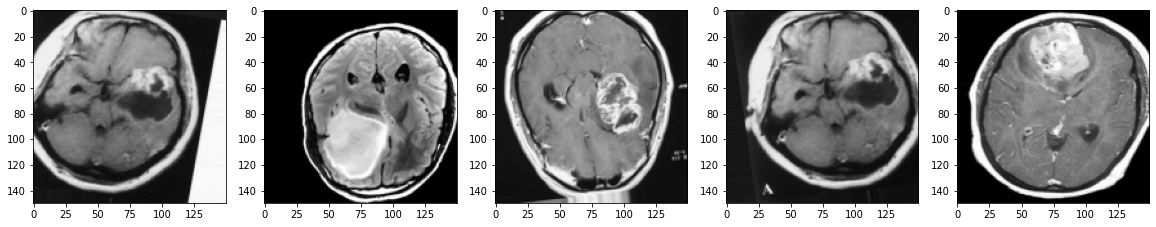

In [21]:
# Displaying few samples from dataset
plt.figure(figsize=(20,10))
columns = 5
for i in range(columns):
    plt.subplot(5/columns + 1, columns, i+1)
    plt.imshow(X[i])

In [23]:
# Create train test split with 20% of data in testing data
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

print('Shape of train images: ', x_train.shape)
print('Shape of train labels: ', y_train.shape)

print()

print('Shape of validation images: ', x_test.shape)
print('Shape of validation labels: ', y_test.shape)

Shape of train images:  (1828, 150, 150, 3)
Shape of train labels:  (1828,)

Shape of validation images:  (458, 150, 150, 3)
Shape of validation labels:  (458,)


In [24]:
# Length of train and validation data
ntrain = len(x_train)
ntest = len(x_test)

In [25]:
# Pre-processing image with the help of image augmentation

train_datagen = ImageDataGenerator(rescale= 1./255, # Normalization.
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip = True,)

# Validation dataset doesn't need image augmentation. Only normalization
test_datagen = ImageDataGenerator(rescale=1./255)

In [26]:
# Defining batch size. It has to be the power of 2
# The batch size tells the data generator to only take the specified batch(16 in our case) of images at a time.
batch_size = 16

# Create image generators using the train and test data
train_generator = train_datagen.flow(x_train, y_train, batch_size=batch_size)
test_generator = test_datagen.flow(x_test, y_test, batch_size=batch_size)

In [28]:
model = Sequential()

# First convolution as the input layer with relu activation. 
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150,150,3)))
model.add(MaxPooling2D((2, 2)))

# Second convolution with relu activation and 64 output filters
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Third convolution with relu activation and 128 output filters
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))


# Flatten the output layer to 1 dimension
model.add(Flatten())

# Add a dropout rate of 0.5 Dropout randomly drops some layers in a neural networks and then learns with the reduced network.
model.add(Dropout(0.5))

# Add a fully connected layer with 100 hidden units and ReLU activation
model.add(Dense(100, activation='relu'))

# Add a final sigmoid layer for classification
model.add(Dense(1, activation='sigmoid'))

#model.summary()

In [29]:
from tensorflow.keras.optimizers import RMSprop

# Compiling the model
# initiate adam optimizer with learning rate 0.0001
opt = keras.optimizers.Adam(lr=0.0001)

# Compiling the model
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [30]:
# Training model
history = model.fit_generator(train_generator,
                             steps_per_epoch= ntrain// batch_size,
                             epochs=15,
                             validation_data=test_generator,
                             validation_steps= ntest// batch_size)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
114/114 [==============================] - 110s 778ms/step - loss: 0.6641 - accuracy: 0.6109 - val_loss: 0.5650 - val_accuracy: 0.7254
Epoch 2/15
114/114 [==============================] - 87s 766ms/step - loss: 0.6153 - accuracy: 0.6656 - val_loss: 0.5569 - val_accuracy: 0.7299
Epoch 3/15
114/114 [==============================] - 90s 789ms/step - loss: 0.6131 - accuracy: 0.6538 - val_loss: 0.5153 - val_accuracy: 0.7344
Epoch 4/15
114/114 [==============================] - 88s 770ms/step - loss: 0.6056 - accuracy: 0.6740 - val_loss: 0.4892 - val_accuracy: 0.7768
Epoch 5/15
114/114 [==============================] - 88s 774ms/step - loss: 0.5658 - accuracy: 0.7109 - val_loss: 0.4962 - val_accuracy: 0.7500
Epoch 6/15
114/114 [==============================] - 89s 784ms/step - loss: 0.5730 - accuracy: 0.7054 - val_loss: 0.5140 - val_accuracy: 0.7321
Epoch 7/15
114/114 [==============================] - 91s 794ms/step - loss: 0.5758 - accuracy: 0.7083 - val_loss: 0.4393 - val_a

In [31]:
# Evaluate model based on accuracy and f1_score
from sklearn.metrics import accuracy_score, f1_score

y_test_predict = model.predict_classes(x_test, verbose=0)
accuracy = accuracy_score(y_test, y_test_predict)
print('Accuracy: %f' % accuracy)

f1 = f1_score(y_test, y_test_predict)
print('F1_score: %f' % f1)

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Accuracy: 0.807860
F1_score: 0.814346


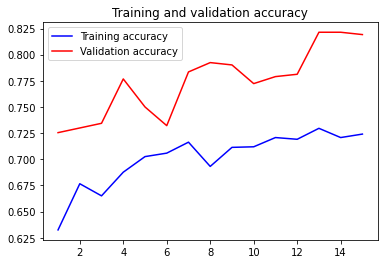

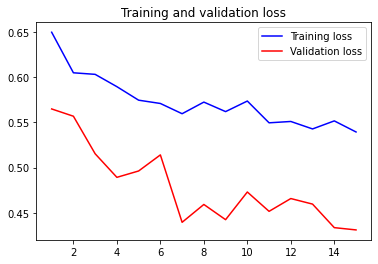

In [32]:
# Plot training and validation accuracy and loss for the model epochs
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

# Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[1]
 This is a tumor image


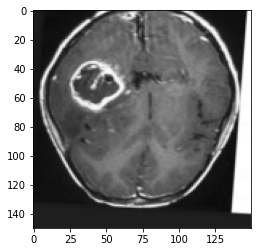

In [36]:
# Example prediction

classes = model.predict_classes(x_test, batch_size=10)
print(classes[97])
plt.imshow(x_test[97])
if classes[97]<0.5:
        print(" This is a non-tumor image")
else:
        print(" This is a tumor image")